# Explorations in Word2Vec

#### Using the dialoge from the Simpson's

## Importing and preprocessing/cleaning the data



Data loading and model based on [this](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook#Materials-for-more-in-depths-understanding:) tutorial.


Dataset used available on Kaggle [here](https://www.kaggle.com/code/ambarish/fun-in-text-mining-with-simpsons/data).

In [1]:
import re  # For preprocessing
import numpy as np
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
df = pd.read_csv('data/simpsons_dataset.csv')

print("Pre-cleanup:\n",df.isnull().sum(),df.shape)

df = df.dropna().reset_index(drop=True) # remove empty lines

print("\nPost-cleanup:\n",df.isnull().sum(),df.shape)

Pre-cleanup:
 raw_character_text    17814
spoken_words          26459
dtype: int64 (158314, 2)

Post-cleanup:
 raw_character_text    0
spoken_words          0
dtype: int64 (131853, 2)


In [3]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [4]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.76 mins


In [5]:
df_clean = pd.DataFrame({'clean': txt, 'character': list(df['raw_character_text'])})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(86383, 2)

## Using Gensim Phrases to discover common phrases


More available [here](https://radimrehurek.com/gensim/models/phrases.html)

In [6]:
from gensim.models.phrases import Phrases, Phraser

In [7]:
sent = [row.split() for row in df_clean['clean']] #split rows into words

In [8]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 17:51:35: collecting all words and their counts
INFO - 17:51:35: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 17:51:35: PROGRESS: at sentence #10000, processed 63507 words and 52613 word types
INFO - 17:51:35: PROGRESS: at sentence #20000, processed 130769 words and 99329 word types
INFO - 17:51:35: PROGRESS: at sentence #30000, processed 192661 words and 137759 word types
INFO - 17:51:35: PROGRESS: at sentence #40000, processed 249531 words and 171589 word types
INFO - 17:51:35: PROGRESS: at sentence #50000, processed 310670 words and 207124 word types
INFO - 17:51:35: PROGRESS: at sentence #60000, processed 372917 words and 242083 word types
INFO - 17:51:35: PROGRESS: at sentence #70000, processed 435619 words and 276832 word types
INFO - 17:51:35: PROGRESS: at sentence #80000, processed 496902 words and 309687 word types
INFO - 17:51:35: collected 329641 token types (unigram + bigrams) from a corpus of 538664 words and 86383 sentences
INFO - 17:51:35: m

Reformat the corpus using the detected ~130 bigrams

In [9]:
bigram = Phraser(phrases)
sentences = bigram[sent]


INFO - 17:51:35: exporting phrases from Phrases<329641 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 17:51:36: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<131 phrases, min_count=30, threshold=10.0> from Phrases<329641 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.40s', 'datetime': '2023-01-30T17:51:36.083120', 'gensim': '4.3.0', 'python': '3.8.15 | packaged by conda-forge | (default, Jan 26 2023, 10:51:07) \n[Clang 14.0.6 ]', 'platform': 'macOS-13.0.1-arm64-i386-64bit', 'event': 'created'}


#### Most frequent words:

In [10]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq), np.array(sorted(word_freq, key=word_freq.get, reverse=True)).T[:10]

(29697,
 array(['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right',
        'look', 'want'], dtype='<U71'))

# Training the model



The followed tutorial did this in 3 steps:

(1.) setup parameters
(2.) build vocabulary
(3.) train model

In [11]:
import multiprocessing

from gensim.models import Word2Vec

In [12]:
cores = multiprocessing.cpu_count()
cores

8

### (1) Parameters

- min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)


- window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)


- size = int - Dimensionality of the feature vectors. - (50, 300)


- sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)


- alpha = float - The initial learning rate - (0.01, 0.05)


- min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00


- negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


- workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [13]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

INFO - 17:51:36: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2023-01-30T17:51:36.543082', 'gensim': '4.3.0', 'python': '3.8.15 | packaged by conda-forge | (default, Jan 26 2023, 10:51:07) \n[Clang 14.0.6 ]', 'platform': 'macOS-13.0.1-arm64-i386-64bit', 'event': 'created'}


### (2) Building the vocabulary

In [14]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 17:51:36: collecting all words and their counts
INFO - 17:51:36: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:51:36: PROGRESS: at sentence #10000, processed 61631 words, keeping 9513 word types
INFO - 17:51:36: PROGRESS: at sentence #20000, processed 127112 words, keeping 14361 word types
INFO - 17:51:36: PROGRESS: at sentence #30000, processed 187410 words, keeping 17412 word types
INFO - 17:51:36: PROGRESS: at sentence #40000, processed 242868 words, keeping 20077 word types
INFO - 17:51:36: PROGRESS: at sentence #50000, processed 302411 words, keeping 22481 word types
INFO - 17:51:36: PROGRESS: at sentence #60000, processed 363076 words, keeping 24779 word types
INFO - 17:51:36: PROGRESS: at sentence #70000, processed 424337 words, keeping 26930 word types
INFO - 17:51:36: PROGRESS: at sentence #80000, processed 484273 words, keeping 28749 word types
INFO - 17:51:36: collected 29697 word types from a corpus of 524821 raw words and 86383 sentence

Time to build vocab: 0.01 mins


### (3) Training the model

In [15]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 17:51:37: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 3332 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2 shrink_windows=True', 'datetime': '2023-01-30T17:51:37.011409', 'gensim': '4.3.0', 'python': '3.8.15 | packaged by conda-forge | (default, Jan 26 2023, 10:51:07) \n[Clang 14.0.6 ]', 'platform': 'macOS-13.0.1-arm64-i386-64bit', 'event': 'train'}
INFO - 17:51:37: EPOCH 0: training on 524821 raw words (200185 effective words) took 0.7s, 299679 effective words/s
INFO - 17:51:38: EPOCH 1: training on 524821 raw words (199897 effective words) took 0.7s, 295247 effective words/s
INFO - 17:51:38: EPOCH 2: training on 524821 raw words (200309 effective words) took 0.5s, 380987 effective words/s
INFO - 17:51:39: EPOCH 3: training on 524821 raw words (200187 effective words) took 0.7s, 287896 effective words/s
INFO - 17:51:40: EPOCH 4: training on 524821 raw words (199761 effective words) took 0.7s, 293362 effective words/s
INFO - 

Time to train the model: 0.32 mins


# Explorations on the trained model

## Following the tutorial

Determine similarity between two words

In [16]:
w2v_model.wv.similarity('maggie','baby')

0.61006165

In [71]:
w2v_model.wv.similarity("moe", 'tavern')

0.8689174

Look at most similar 10 words (this is not the what homer says, but is said about homer)

In [17]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.7630440592765808),
 ('depressed', 0.7242069840431213),
 ('sake', 0.686842679977417),
 ('gee', 0.6837700605392456),
 ('sweetheart', 0.6791550517082214),
 ('crummy', 0.6745020151138306),
 ('snuggle', 0.6720924377441406),
 ('humiliate', 0.6656530499458313),
 ('glad', 0.6630297303199768),
 ('rude', 0.6606558561325073)]

What words are like to woman as bart as are to man

In [76]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"])

[('lisa', 0.718111515045166),
 ('assignment', 0.6735084652900696),
 ('dr_hibbert', 0.6399227380752563),
 ('pregnant', 0.6356645226478577),
 ('pay_attention', 0.6311306357383728),
 ('parent', 0.6310505270957947),
 ('surprised', 0.6207395195960999),
 ('mom', 0.602746844291687),
 ('substitute', 0.6010058522224426),
 ('jealous', 0.5999953746795654)]

Lisa seems quite accurate tbf

Who is the odd one out from the friendship circle?

In [68]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

## Looking into visualisation


Modified the code from [here](
https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py)

In [19]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

t = time()

def reduce_dimensions(model):
    num_dimensions = 3  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(w2v_model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)

print('Time to plot: {} mins'.format(round((time() - t) / 60, 2)))

Time to plot: 0.26 mins


### Next from the tutorial

In [20]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=2).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

#### Comparing words most similar to Maggie to words most dissimilar

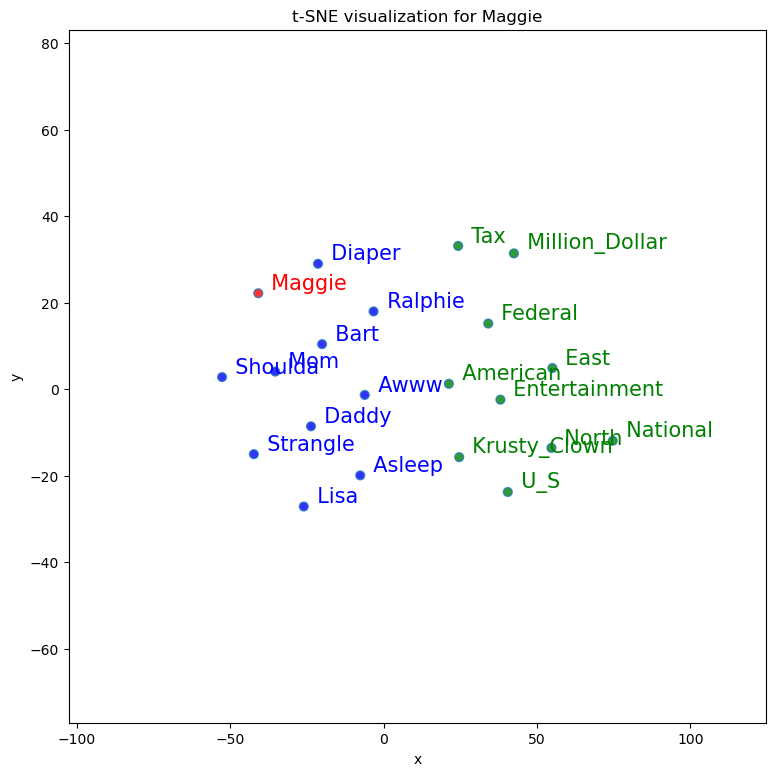

In [21]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

## Aggregating the dialoges by characters

### Aggregate the dataframe

In [22]:
corpus_by_speaker = df_clean.groupby(by='character',as_index=False).agg({ 'character' : 'first','clean' : ' '.join})
corpus_by_speaker['clean'] = corpus_by_speaker['clean'].str.split()


len(corpus_by_speaker['clean'].iloc[3089])

650

### Vectorizing lists of character speeches

Based on what a character said, we can generate an overall sentiment of what he/she/it said. This is (for simplicity) represented by the average of the vector representation of words in their dialouge.

Using [this](https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/) simple code I found originally intended for categorising documents



In [23]:
def vectorize(list_of_docs, model):
    
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

vectorised_by_speaker = vectorize(corpus_by_speaker['clean'], w2v_model)
    

### Plotting the vectors of each character (using plotly)

There are 5000+ characters, thus this plot is quite full too.

In [51]:
def squash_to_plot(vectorised_by_speaker, corpus_by_speaker):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(vectorised_by_speaker)
    labels = np.asarray(corpus_by_speaker)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

x, y, labels = squash_to_plot(vectorised_by_speaker, corpus_by_speaker['character'])

plot_function(x, y, labels)


### Clustering characters based on their dialoges

Using sklearn simply. More [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans)

In [25]:
from sklearn.cluster import MiniBatchKMeans

In [79]:
vectorised_by_speaker = np.array(vectorised_by_speaker)

kmeans = MiniBatchKMeans(n_clusters=46,
                        random_state=0,
                        batch_size=32,
                        max_iter=20,
                        n_init="auto").fit(vectorised_by_speaker,y=labels)



Based on a bit of manual hyperparameter tuning, I aimed to make the clusters relatively balanced. The clusters are then stored in a new dataframe

In [80]:
assignments = pd.DataFrame({'character': labels,'group': kmeans.labels_})

assignments.groupby('group').count().sort_values(by='character',ascending=False)

,character
group,
38,882
2,440
19,393
10,275
24,256
17,217
4,197
34,170
1,158


Let's look at where 'Homer' characters were clustered

In [81]:
assignments[assignments['character'].str.contains("Homer")].sort_values(by='group')

,character,group
2180,Homer Actor,0
2194,Homer's Recording,2
4888,Viking Homer,2
4176,Serious Homer,3
2200,Homer-ish Husband,4
99,8-Year-Old Homer,4
2190,Homer's Conscience,6
2196,Homer's Stomach,8
3691,Present-Day Homer,10
931,Christian Homer,12


Let's look at the distribution of the above

In [29]:
assignments[assignments['character'].str.contains("Homer")].sort_values(by='group').groupby('group').count()

,character
group,
0,1
2,2
3,1
4,2
6,1
8,1
10,1
12,1
14,4


Looking into a specific cluster, note that the similarities between character names were never considered. Any relationship is only based on their proximity.

In [50]:
assignments[assignments['group']==14][50:70]

,character,group
1770,Freaks,14
1795,Fry Cook,14
1955,Goofy Recording,14
2017,Guilden-Lenny,14
2058,HOTDOG VENDOR,14
2069,Halpern,14
2133,Hibbert Boy,14
2191,Homer's Feet,14
2213,Hot Dog Man,14
2215,Hot Dog Vendor,14


# Future work


This new vector set of 'vectorised_by_character' could also be added to the original vocabulary, which could allow more exploration of what things each character had said.